In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from imblearn.pipeline import Pipeline as ImbPipeline
from category_encoders import TargetEncoder


# Data Preprocessing and Loading

In [7]:
df = pd.read_csv('../../Final Model/data/preprocessed_log_data.csv', encoding='windows-1252')

In [8]:
df.shape

(162294, 14)

In [9]:
# Keep only rows where Label is not zero
df = df[df['Label'] != 0]

# Drop the Label column
df = df.drop(columns=['Label'])

df.shape

(140254, 13)

In [10]:
df.head()

,TaskName,Odometer,Make,Model,Year,FuelType,EngineSize,Transmission,DriveType,IsHybrid,Distance,Months,AdjustedPrice
1,Logbook Service,72199.0,SKODA,SKODA FABIA III,2017,Petrol,1.0,Auto,NaN,0.0,75000.0,60.0,703.0
4,Logbook Service,81168.0,MAZDA,MAZDA CX-9,2018,Petrol,2.5,Auto,2WD,0.0,80000.0,96.0,581.0
5,Logbook Service,33541.0,MAZDA,MAZDA 3,2017,Petrol,2.0,Auto,NaN,0.0,60000.0,72.0,380.0
6,Logbook Service,54040.0,TOYOTA,TOYOTA HILUX,2015,Diesel,2.8,Auto,4WD,0.0,60000.0,36.0,473.0
8,Logbook Service,40557.0,FORD,FORD RANGER,2021,Diesel,2.0,Auto,4WD,0.0,45000.0,36.0,650.0


In [11]:
X = df.drop(columns=['AdjustedPrice'])
y = df['AdjustedPrice']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model

In [13]:
# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing values with mean
    ('scaler', StandardScaler()) # Scale numeric features (standardize))
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing values with most frequent
    ('target_encoder', TargetEncoder()) # Encode categorical features using target encoding
])


# Combine preprocessors

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create a pipeline with preprocessing and classifier

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter grid for Random Forest Random Forest
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 4, 8],
    'regressor__min_samples_leaf': [1, 2, 4, 8],
    'regressor__max_features': [None, 'sqrt', 'log2'],
    'regressor__bootstrap': [True, False]
}

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=50,  # number of parameter settings sampled
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Predict on test set
y_pred = random_search.predict(X_test)



Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

In [15]:
# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

# Best parameters
print("Best Parameters:", random_search.best_params_)
print(f"Test MAE: {mae:.2f}")
print(f"Test MAPE: {mape:.2f}")
print(f"Test RMSE: {rmse:.2f}")
# Approval decision based on ±20% margin
margin = 0.20
approval = np.abs(y_test - y_pred) / y_pred <= margin
approval_rate = approval.mean()
print(f"Approval Rate (±{margin*100:.0f}% margin): {approval_rate:.2%}")

Best Parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 4, 'regressor__max_features': None, 'regressor__max_depth': 20, 'regressor__bootstrap': True}
Test MAE: 90.77
Test MAPE: 17.24
Test RMSE: 153.51
Approval Rate (±20% margin): 73.95%


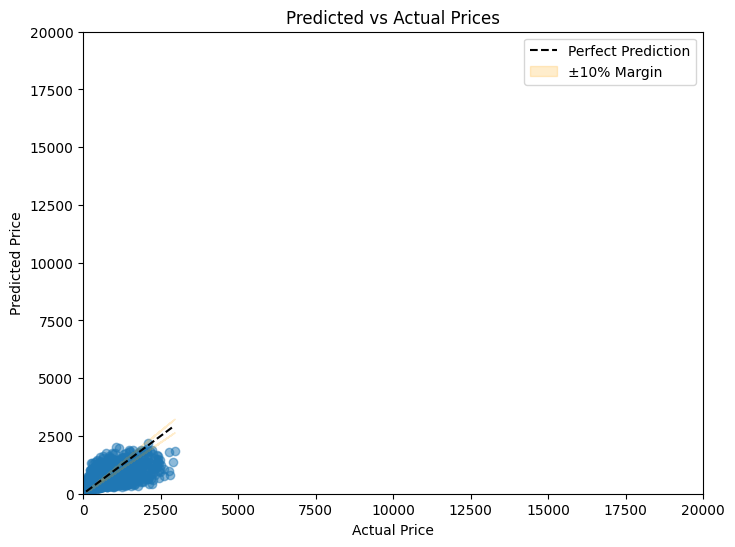

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Perfect Prediction')

# ±10% bounds
lower_bound = y_test * 0.9
upper_bound = y_test * 1.1
plt.fill_between(y_test, lower_bound, upper_bound, color='orange', alpha=0.2, label='±10% Margin')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.legend()
plt.xlim(0, 20000)
plt.ylim(0, 20000)
plt.show()

In [17]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.6387


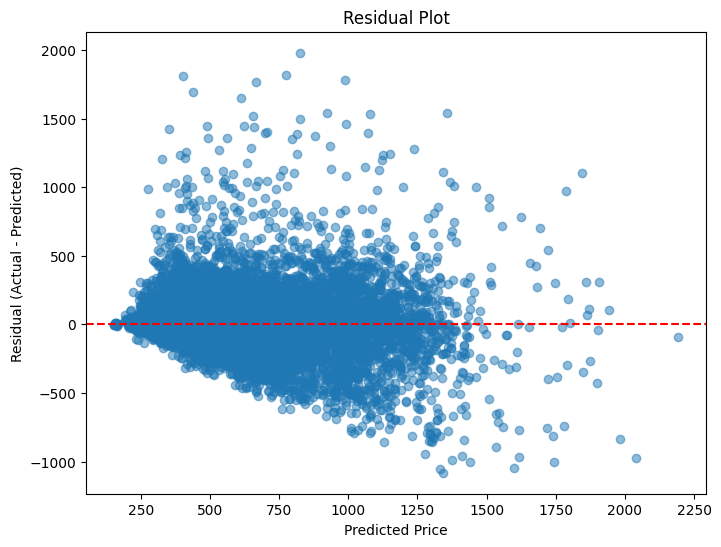

In [18]:
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

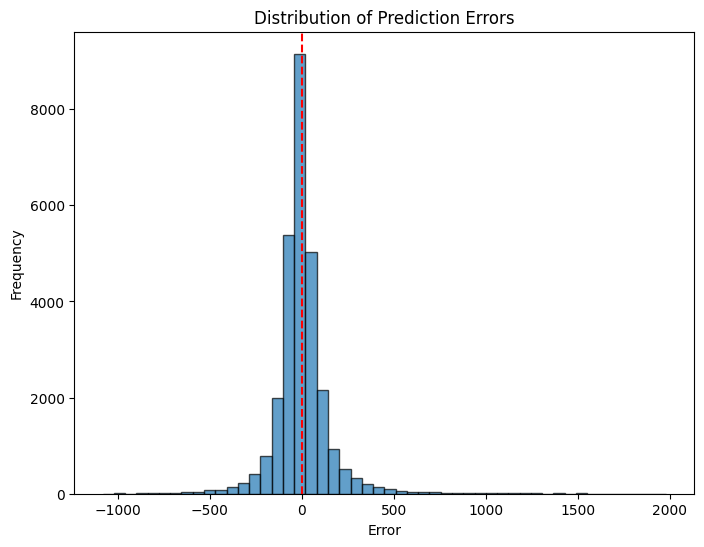

In [19]:
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

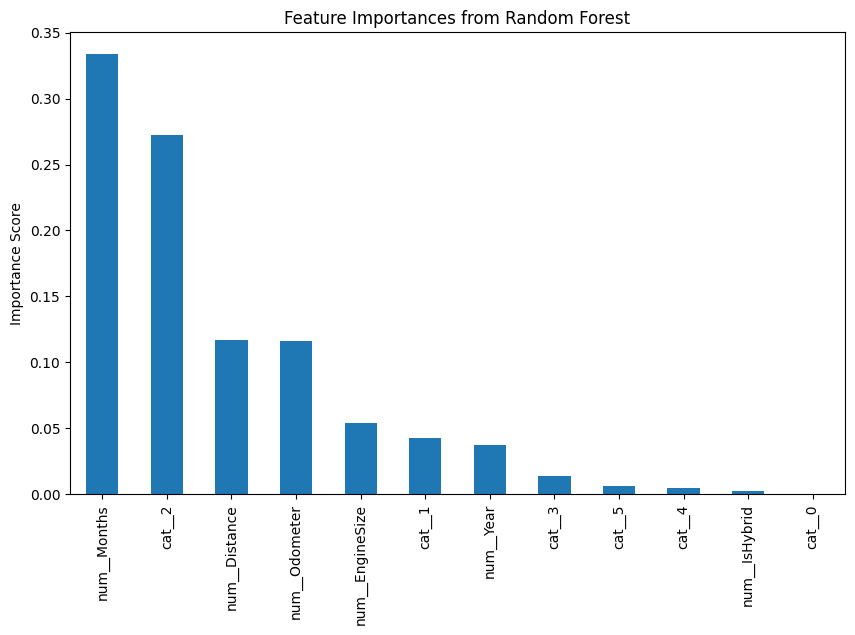

In [20]:
# Extract the fitted preprocessor from the best pipeline
fitted_preprocessor = random_search.best_estimator_.named_steps['preprocessor']

# Now get the feature names
feature_names = fitted_preprocessor.get_feature_names_out()

# Get feature importances from the trained RandomForest
importances = random_search.best_estimator_.named_steps['regressor'].feature_importances_

# Create a Series for sorting and plotting
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
feat_imp.plot(kind='bar')
plt.title("Feature Importances from Random Forest")
plt.ylabel("Importance Score")
plt.show()

C:\Users\jackl\AppData\Local\Temp\ipykernel_36852\562759287.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_rate = pd.DataFrame({"PriceBin": price_bins, "Approved": approval}).groupby("PriceBin").mean()


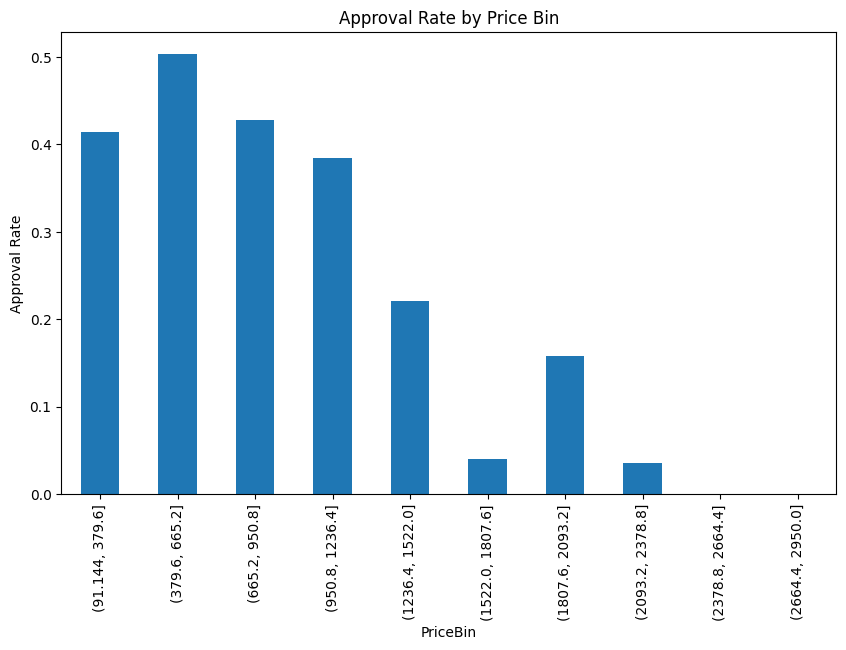

In [21]:
approval = ((y_pred >= y_test * 0.9) & (y_pred <= y_test * 1.1)).astype(int)
price_bins = pd.cut(y_test, bins=10)
approval_rate = pd.DataFrame({"PriceBin": price_bins, "Approved": approval}).groupby("PriceBin").mean()

approval_rate.plot(kind='bar', legend=False, figsize=(10,6))
plt.ylabel("Approval Rate")
plt.title("Approval Rate by Price Bin")
plt.show()

In [22]:
print(df['Label'].value_counts(normalize=True))

KeyError: 'Label'